## Семинар 6 "Segmentation"

ФИО: Вахрушев Вадим Юрьевич

ник на drive - vakhrushev_vadim_sphere

## Задание

Предлагается поучаствовать в конкурсе https://drive.grand-challenge.org/

Для зачета требуется получить значение dice-coefficient на leaderboard не меньше 0.8 и прислать ноутбук с кодом и кратким отчетом: что пробовали, что сделали, мысли почему окончательная архитектура лучше остальных.

Называйте своего юзера с суффиксом [sphere].

Также первые 3 человека получат бонусные 6, 4, 2 балл соответственно. (deadline: 23:59 14 апреля 2019). Скорее всего будут дополнительные плюшки для призеров конкурса.


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch as t
from torch.utils import data
from torchvision import transforms as tsf
import scipy.misc
import torch
from pathlib import Path

from PIL import Image
import skimage
from skimage import io


TRAIN_PATH = './train.pth'
TEST_PATH = './test.tph'
%matplotlib inline

In [3]:
def process(dataset_path, mask_path=None):
    data = []
    if mask_path:
        mask_path = Path(mask_path)

    for image in sorted(Path(dataset_path).iterdir()):
        item = {}
        img = io.imread(image)
        
        if img.shape[2]>3:
            assert(img[:,:,3]!=255).sum()==0
        
        img = img[:,:,:3]
        item['name'] = image.name.split("_")[0]
        item['img'] = t.from_numpy(img)
        if mask_path:
            mask = io.imread(mask_path/(item['name'] + "_manual1.gif"))
            item['mask'] = t.from_numpy(mask)
        data.append(item)
    
    return data
test = process('test/images/')
t.save(test, TEST_PATH)
train_data = process('train/images', "train/1st_manual/")

/home/sargeras/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/imageio/plugins/_tifffile.py:8388: UserWarning: unexpected end of LZW stream (code 0)
  warnings.warn('unexpected end of LZW stream (code %i)' % code)


In [4]:
from PIL import Image

In [5]:
from random import seed
from random import random

In [5]:
seed(1)

In [6]:
import PIL
class Dataset():
    def __init__(self,data,source_transform,target_transform):
        self.datas = data
        self.s_transform = source_transform
        self.t_transform = target_transform
    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        deg = random() * 360
        img = tsf.ToPILImage()(img).rotate(deg)
        mask = data['mask'][:,:,None].byte().numpy()
        mask = tsf.ToPILImage()(mask).rotate(deg)
        img = self.s_transform(img)
        mask = self.t_transform(mask)
        return img, mask
    def __len__(self):
        return len(self.datas)
s_trans = tsf.Compose([
    tsf.Resize((400,400)),
    tsf.ToTensor(),
    tsf.Normalize(mean = [0.5,0.5,0.5],std = [0.5,0.5,0.5]),

]
)
t_trans = tsf.Compose([

    tsf.Resize((400,400),interpolation=PIL.Image.NEAREST),
    tsf.ToTensor(),
]
)
dataset = Dataset(train_data,s_trans,t_trans)
dataloader = t.utils.data.DataLoader(dataset,num_workers=2,batch_size=4)

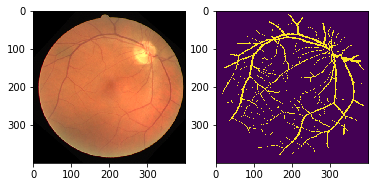

In [7]:
img,mask = dataset[12]
plt.subplot(121)
plt.imshow(img.permute(1,2,0).numpy()*0.5+0.5)
plt.subplot(122)
plt.imshow(mask[0].numpy())

In [8]:
# sub-parts of the U-Net model

from torch import nn
import torch.nn.functional as F


class double_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=False):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
        # for padding issues, see 
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd

        x = t.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        x = t.nn.functional.sigmoid(x)
        return x

In [9]:
# Попробуйте использовать различные функции потерь.
def soft_dice_loss(inputs, targets):
        num = targets.size(0)
        m1  = inputs.view(num,-1)
        m2  = targets.view(num,-1)
        intersection = (m1 * m2)
        score = 2. * (intersection.sum(1)+1) / (m1.sum(1) + m2.sum(1)+1)
        score = 1 - score.sum()/num
        return score

In [10]:
train_loader = t.utils.data.DataLoader(dataset, batch_size=3, shuffle=True)

In [11]:
def train(loader, epochs, model, step):
    optimizer = t.optim.Adam(model.parameters(), lr=step)
    train_loss_epochs = []
    model = model.train()
    try:
        for epoch in tqdm(range(epochs)):
            
            losses = []
            for X, y in loader:
                #X = X.type(np.dtype(float))
                prediction = model(X)
                loss_batch = soft_dice_loss(prediction, y)
                losses.append(loss_batch.item())
                optimizer.zero_grad()
                loss_batch.backward()
                optimizer.step()
            train_loss_epochs.append(np.mean(losses))
            #clear_output(True)
            print('Epoch {0}... Loss: {1:.3f}'.format(
                        epoch, train_loss_epochs[-1]))
            plt.figure(figsize=(12, 5))
            plt.plot(train_loss_epochs)
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.grid()
            plt.show()
    except KeyboardInterrupt:
        if tolerate_keyboard_interrupt:
            pass
        else:
            raise KeyboardInterrupt
    return train_loss_epochs

In [12]:
import pickle
with open('modelnewyyy.piclke', 'rb') as f:
    model = pickle.load(f)

  0%|          | 0/500 [00:00<?, ?it/s]/home/sargeras/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 0... Loss: 0.199


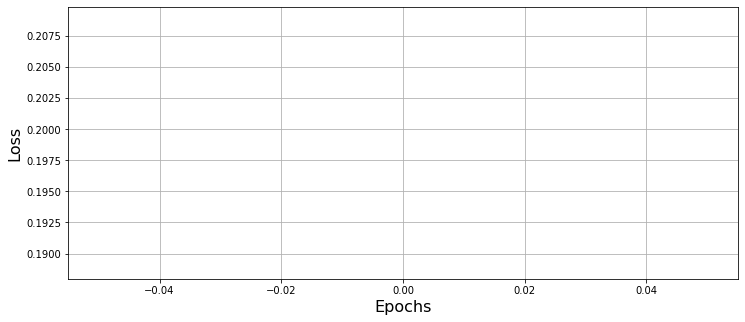

  0%|          | 1/500 [01:12<10:03:53, 72.61s/it]

Epoch 1... Loss: 0.200


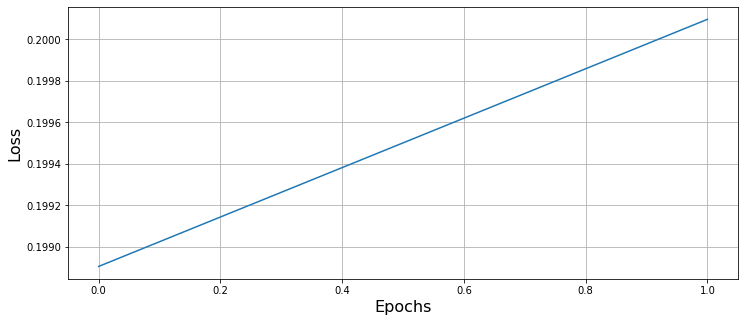

  0%|          | 2/500 [02:28<10:10:11, 73.52s/it]

Epoch 2... Loss: 0.200


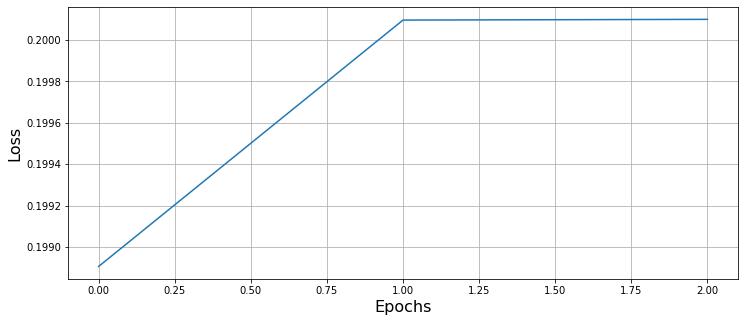

  1%|          | 3/500 [03:45<10:18:55, 74.72s/it]

Epoch 3... Loss: 0.200


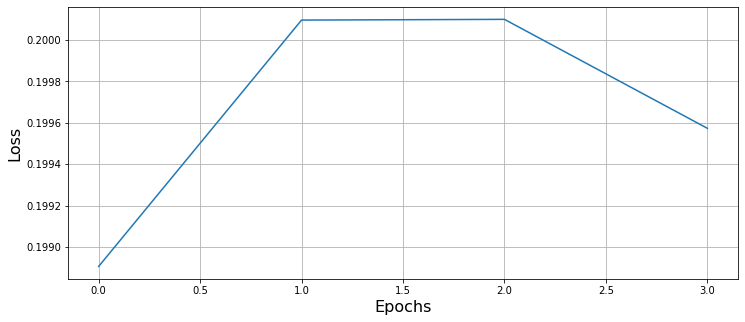

  1%|          | 4/500 [05:14<10:51:58, 78.87s/it]

Epoch 4... Loss: 0.199


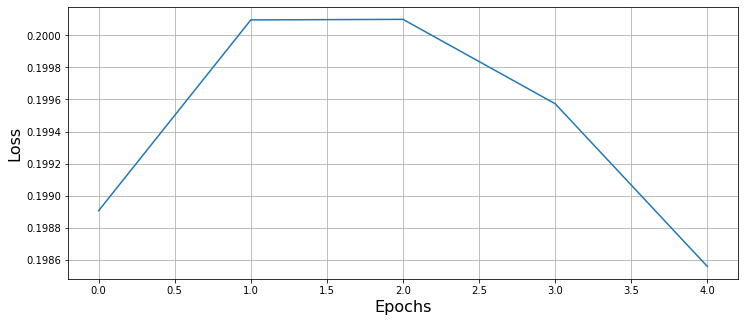

  1%|          | 5/500 [06:33<10:51:49, 79.01s/it]

Epoch 5... Loss: 0.199


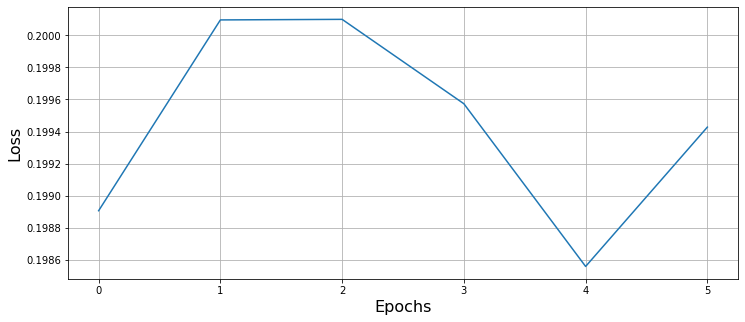

  1%|          | 6/500 [07:53<10:52:08, 79.21s/it]

Epoch 6... Loss: 0.198


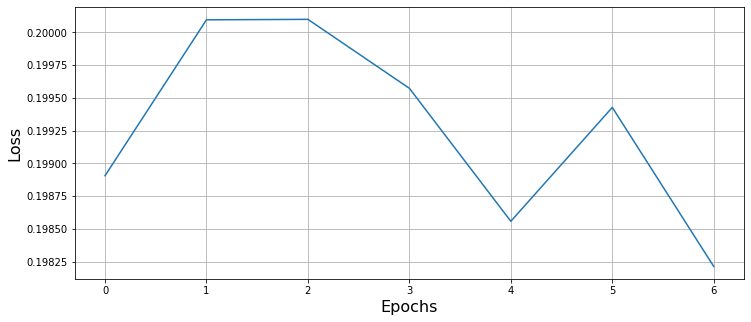

  1%|▏         | 7/500 [09:12<10:51:54, 79.34s/it]

Epoch 7... Loss: 0.199


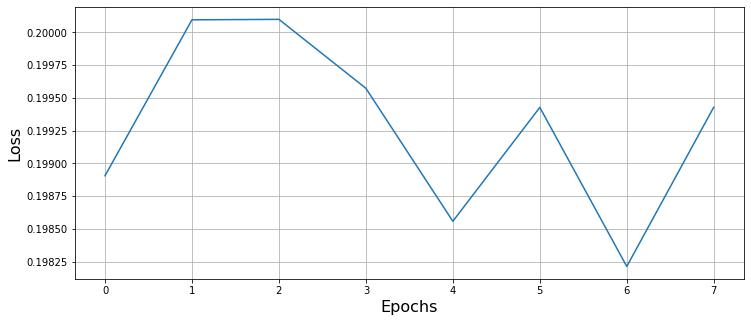

  2%|▏         | 8/500 [10:39<11:07:04, 81.35s/it]

Epoch 8... Loss: 0.199


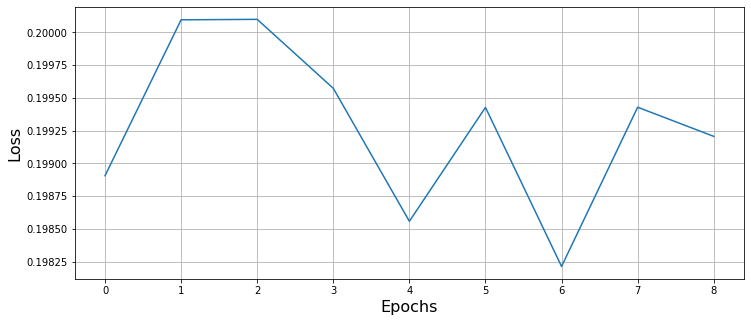

  2%|▏         | 9/500 [12:01<11:08:11, 81.65s/it]

Epoch 9... Loss: 0.199


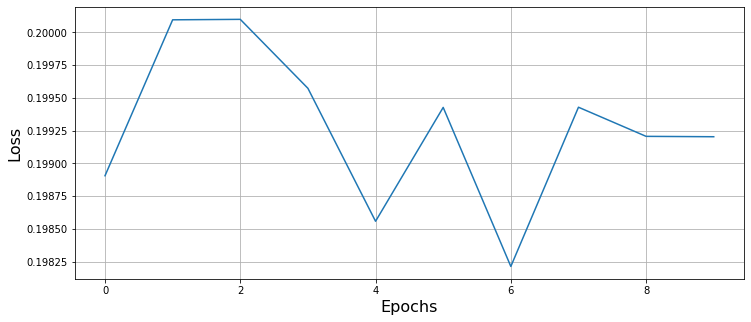

  2%|▏         | 10/500 [13:24<11:09:36, 81.99s/it]

Epoch 10... Loss: 0.200


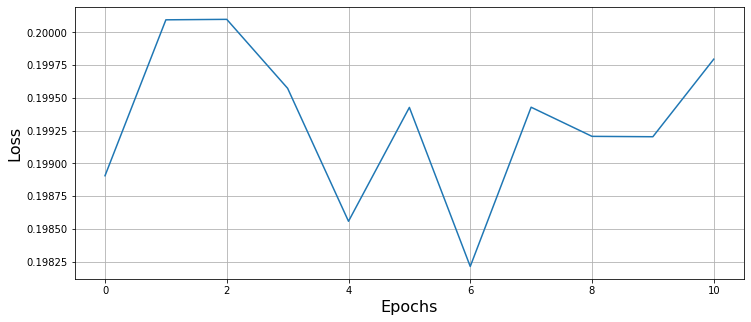

  2%|▏         | 11/500 [14:40<10:54:34, 80.32s/it]

Epoch 11... Loss: 0.201


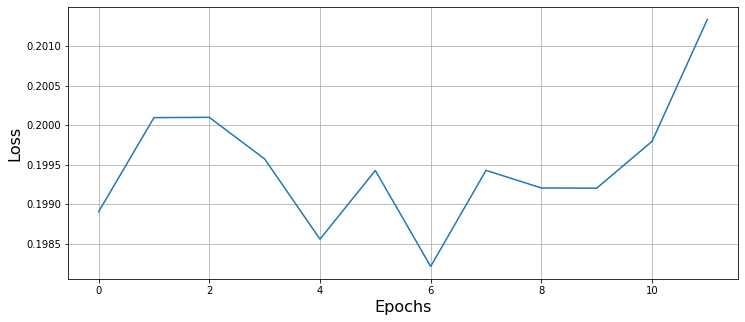

  2%|▏         | 12/500 [16:03<11:00:19, 81.19s/it]

Epoch 12... Loss: 0.198


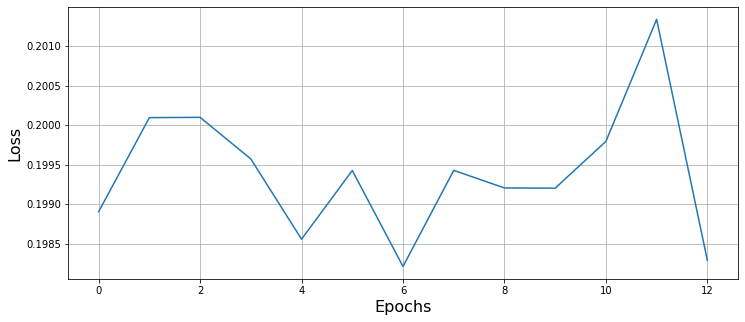

  3%|▎         | 13/500 [17:43<11:43:14, 86.64s/it]

Epoch 13... Loss: 0.199


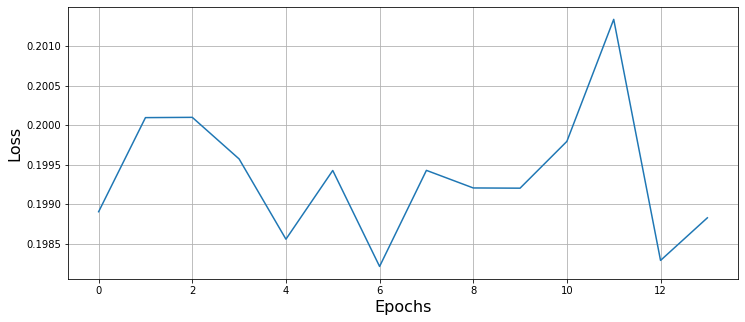

  3%|▎         | 14/500 [19:24<12:18:33, 91.18s/it]

Epoch 14... Loss: 0.198


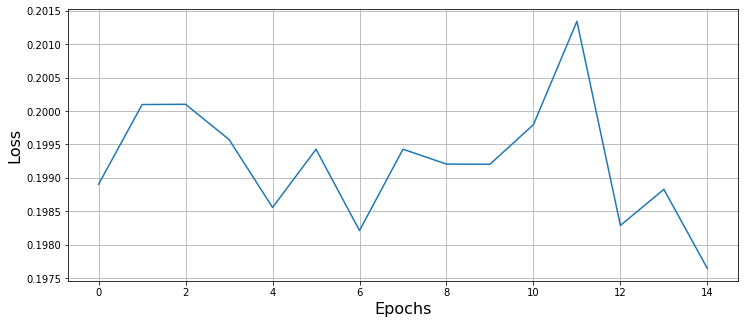

  3%|▎         | 15/500 [21:18<13:10:14, 97.76s/it]

Epoch 15... Loss: 0.198


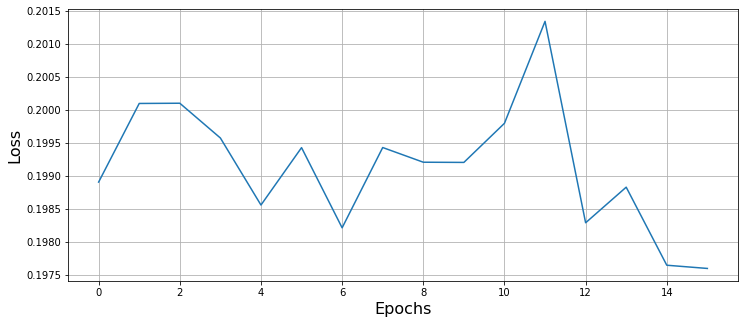

  3%|▎         | 16/500 [23:11<13:46:20, 102.44s/it]

Epoch 16... Loss: 0.198


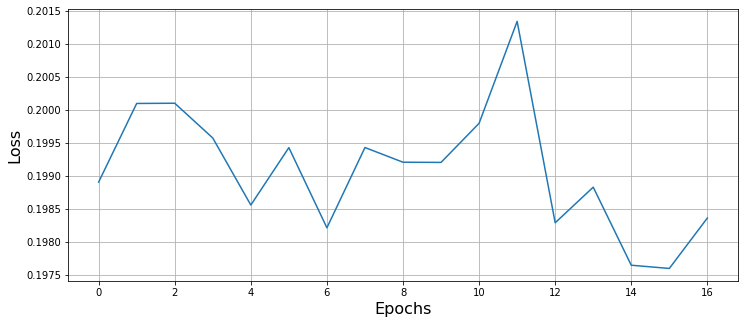

  3%|▎         | 17/500 [25:01<14:03:14, 104.75s/it]

Epoch 17... Loss: 0.199


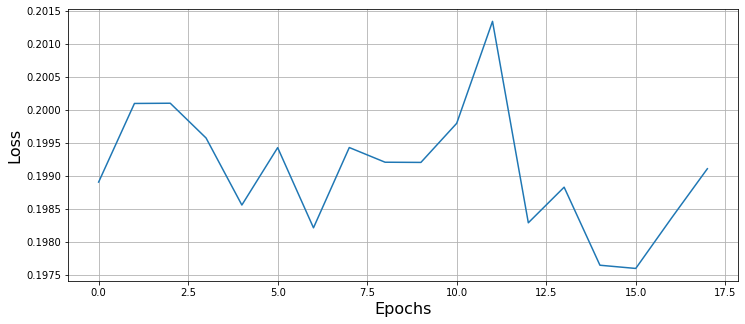

  4%|▎         | 18/500 [26:51<14:14:38, 106.39s/it]

Epoch 18... Loss: 0.199


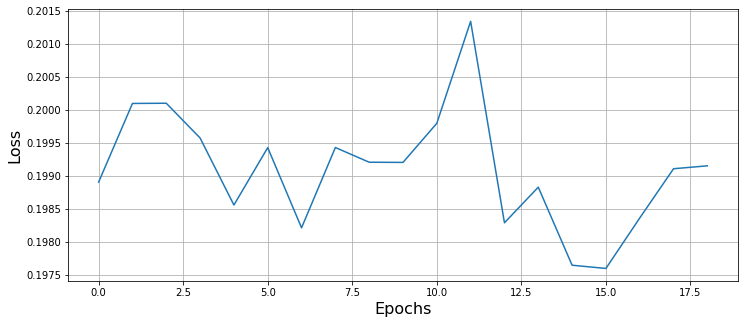

  4%|▍         | 19/500 [28:41<14:20:39, 107.36s/it]

Epoch 19... Loss: 0.197


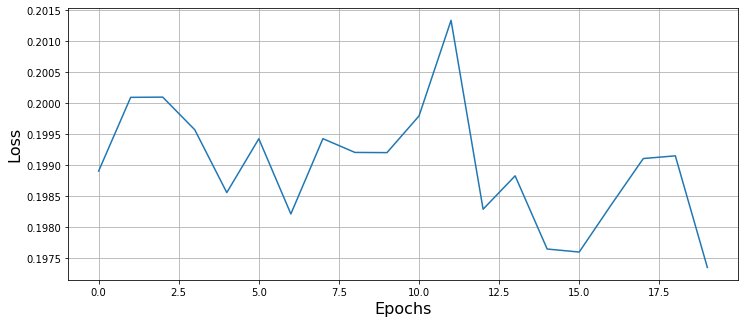

  4%|▍         | 20/500 [30:30<14:22:16, 107.78s/it]

Epoch 20... Loss: 0.198


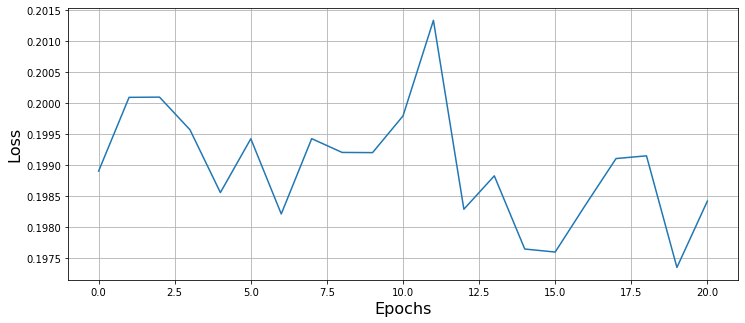

  4%|▍         | 21/500 [32:20<14:25:38, 108.43s/it]

Epoch 21... Loss: 0.198


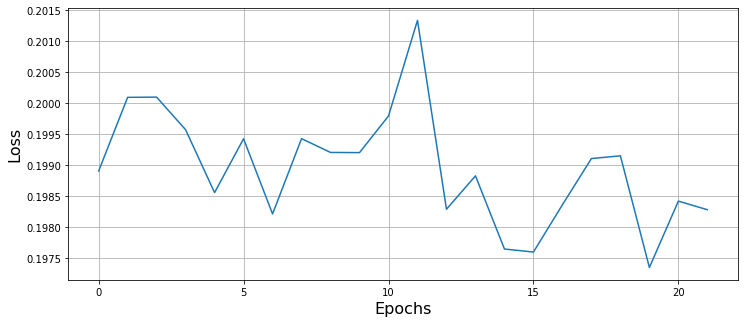

  4%|▍         | 22/500 [34:09<14:26:07, 108.72s/it]

Epoch 22... Loss: 0.200


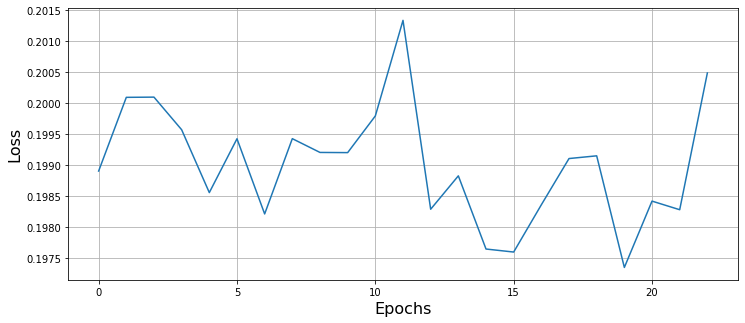

  5%|▍         | 23/500 [36:00<14:29:54, 109.42s/it]

Epoch 23... Loss: 0.199


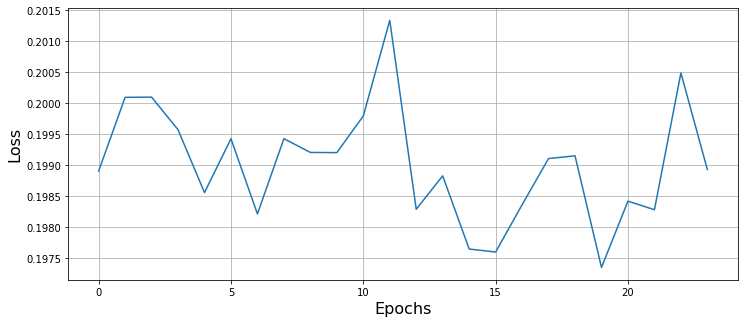

  5%|▍         | 24/500 [37:51<14:32:24, 109.97s/it]

Epoch 24... Loss: 0.198


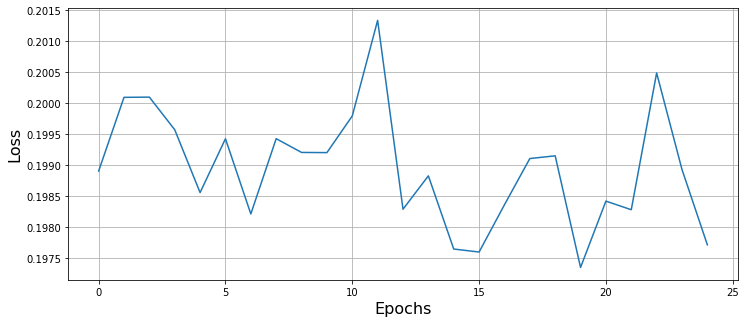

  5%|▌         | 25/500 [39:42<14:31:25, 110.07s/it]

Epoch 25... Loss: 0.196


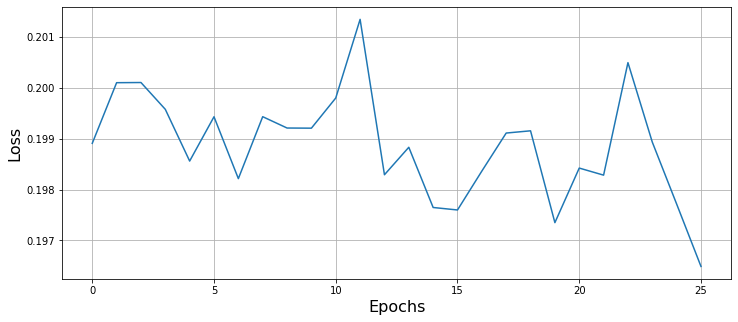

  5%|▌         | 26/500 [41:33<14:33:46, 110.60s/it]

Epoch 26... Loss: 0.196


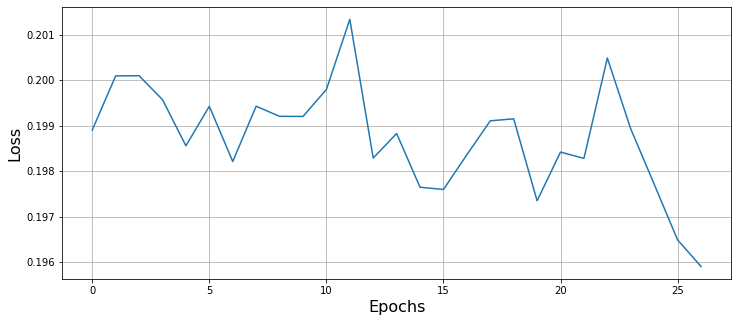

  5%|▌         | 27/500 [43:23<14:30:35, 110.43s/it]

Epoch 27... Loss: 0.197


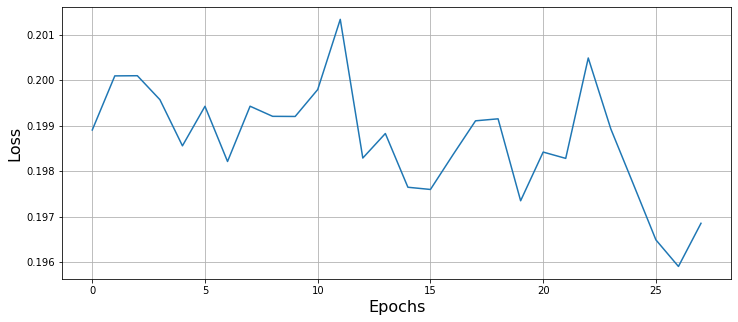

  6%|▌         | 28/500 [45:17<14:35:12, 111.25s/it]

Epoch 28... Loss: 0.198


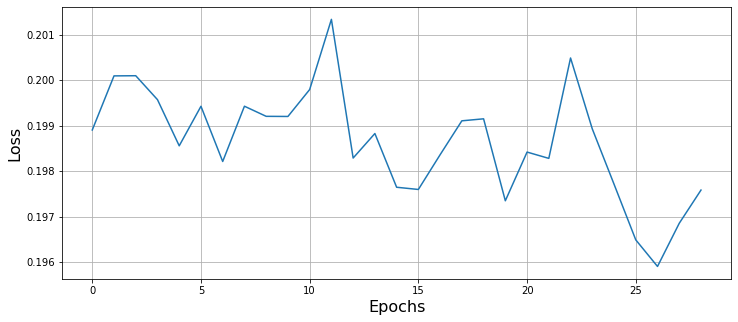

  6%|▌         | 29/500 [47:10<14:38:28, 111.91s/it]

Epoch 29... Loss: 0.196


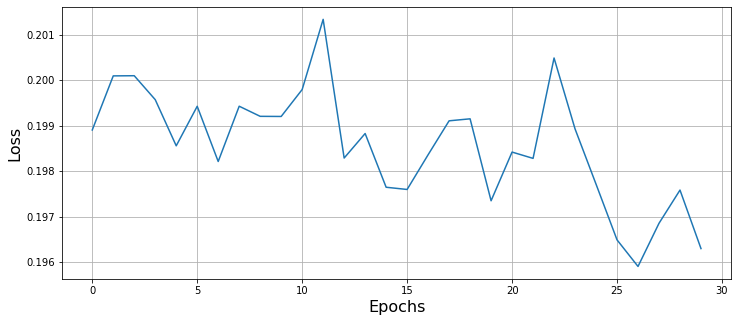

  6%|▌         | 30/500 [49:03<14:39:27, 112.27s/it]

Epoch 30... Loss: 0.196


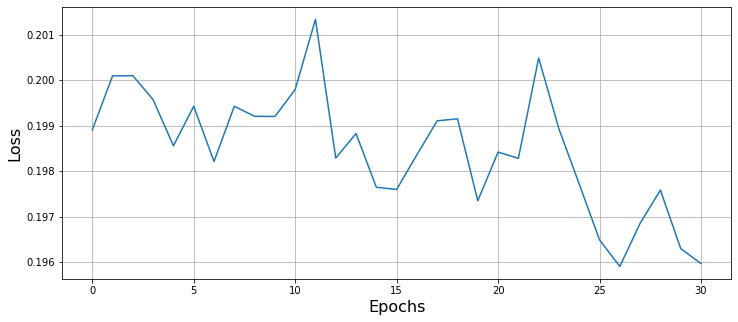

  6%|▌         | 31/500 [50:56<14:37:57, 112.32s/it]

Epoch 31... Loss: 0.197


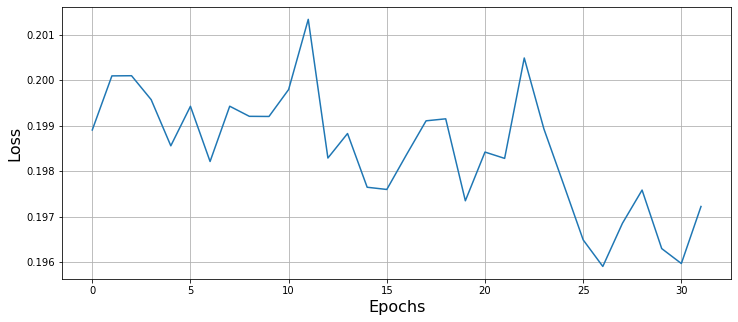

  6%|▋         | 32/500 [52:48<14:37:22, 112.49s/it]

Epoch 32... Loss: 0.198


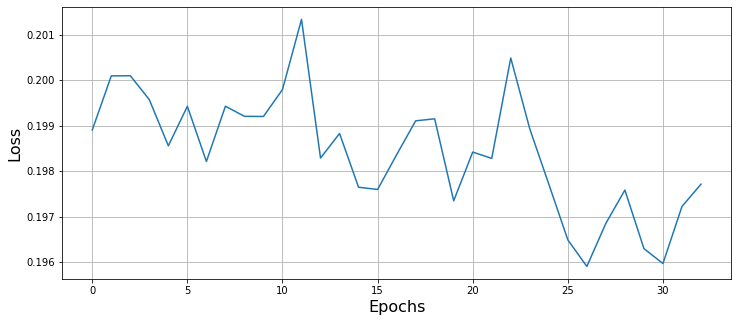

  7%|▋         | 33/500 [54:43<14:39:49, 113.04s/it]

Epoch 33... Loss: 0.199


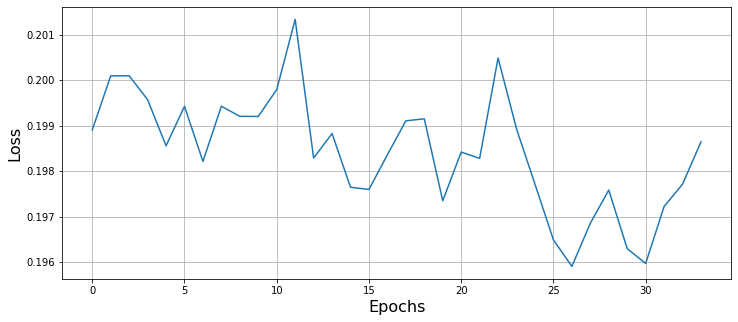

  7%|▋         | 34/500 [56:36<14:37:49, 113.02s/it]

Epoch 34... Loss: 0.197


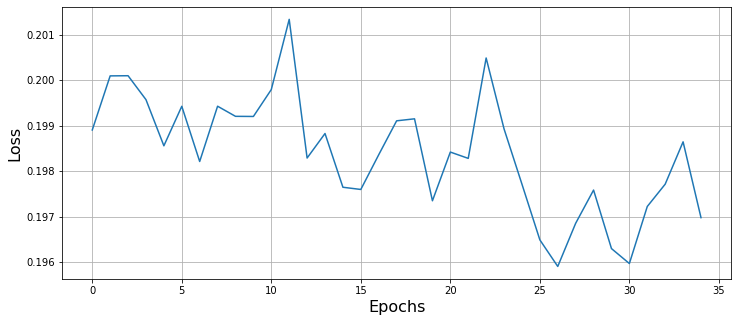

  7%|▋         | 35/500 [58:28<14:33:58, 112.77s/it]

Epoch 35... Loss: 0.197


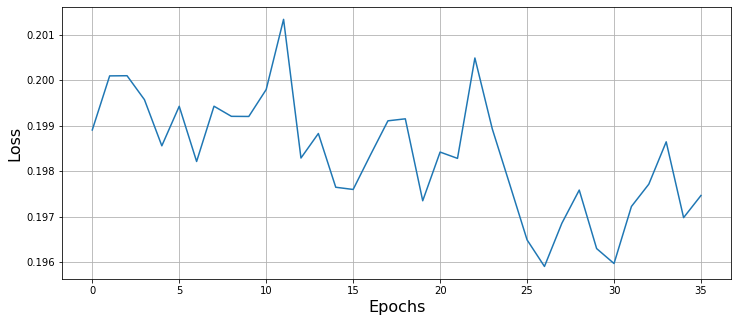

  7%|▋         | 36/500 [1:00:21<14:31:52, 112.74s/it]

Epoch 36... Loss: 0.199


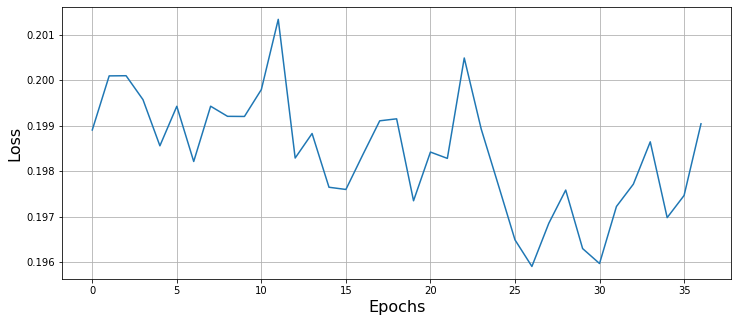

  7%|▋         | 37/500 [1:02:15<14:32:58, 113.13s/it]

Epoch 37... Loss: 0.197


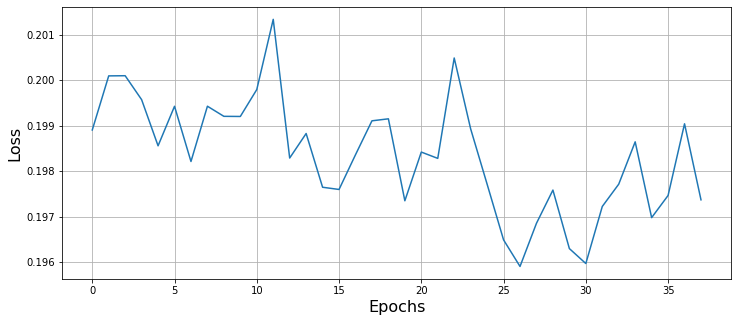

  8%|▊         | 38/500 [1:04:09<14:34:23, 113.56s/it]

Epoch 38... Loss: 0.199


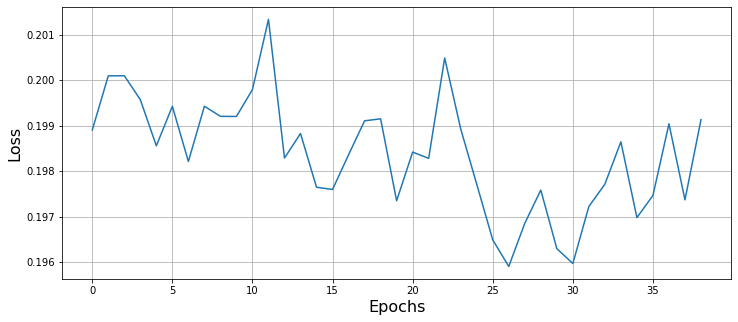

  8%|▊         | 39/500 [1:06:03<14:32:32, 113.56s/it]

Epoch 39... Loss: 0.198


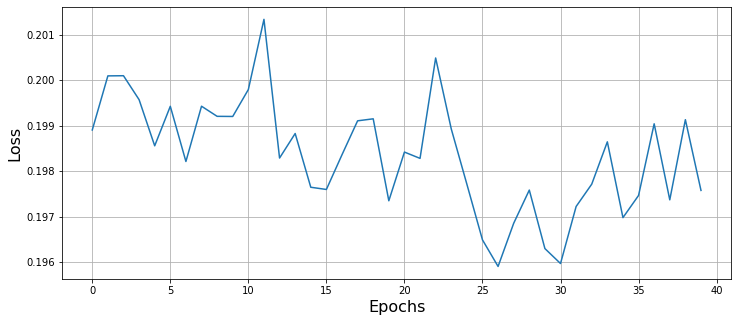

  8%|▊         | 40/500 [1:07:57<14:32:09, 113.76s/it]

Epoch 40... Loss: 0.197


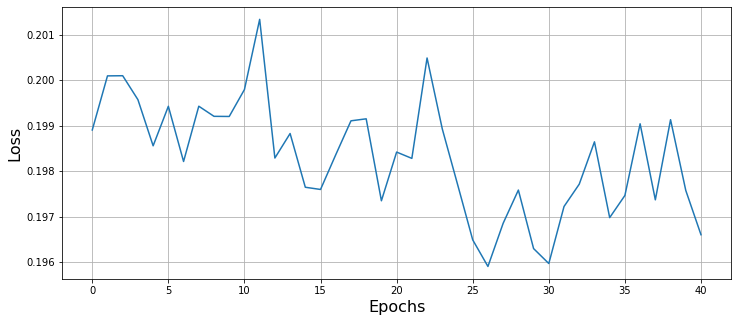

  8%|▊         | 41/500 [1:09:52<14:32:15, 114.02s/it]

Epoch 41... Loss: 0.197


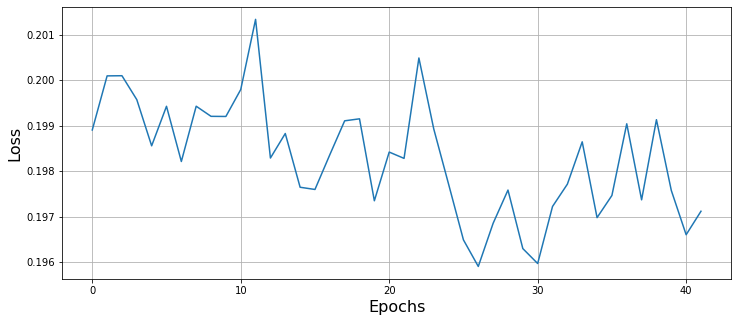

  8%|▊         | 42/500 [1:11:44<14:26:59, 113.58s/it]

Epoch 42... Loss: 0.196


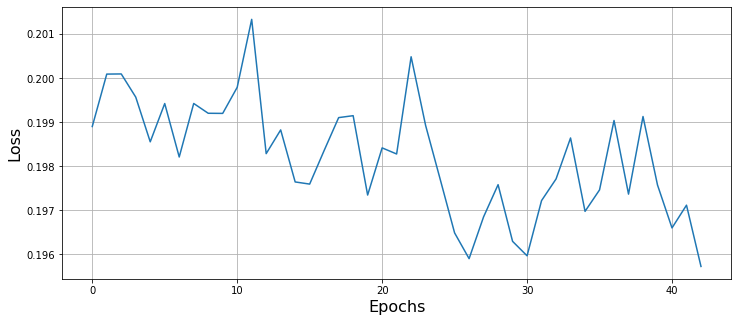

  9%|▊         | 43/500 [1:13:37<14:24:01, 113.44s/it]

Epoch 43... Loss: 0.198


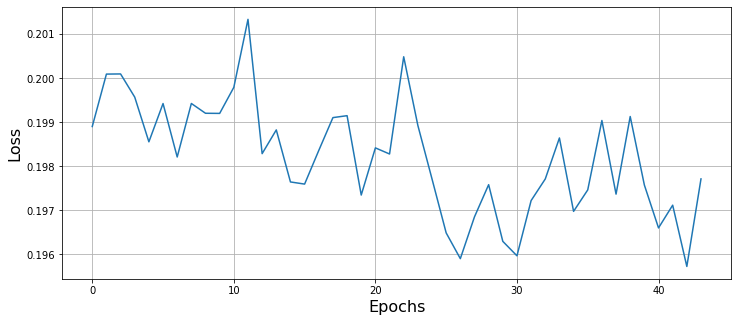

  9%|▉         | 44/500 [1:15:31<14:22:34, 113.50s/it]

Epoch 44... Loss: 0.198


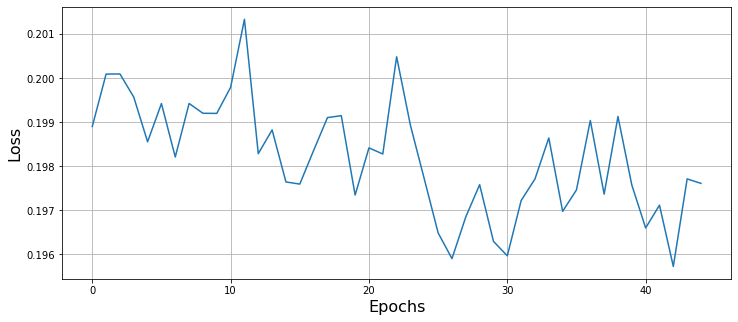

  9%|▉         | 45/500 [1:17:25<14:21:48, 113.65s/it]

Epoch 45... Loss: 0.197


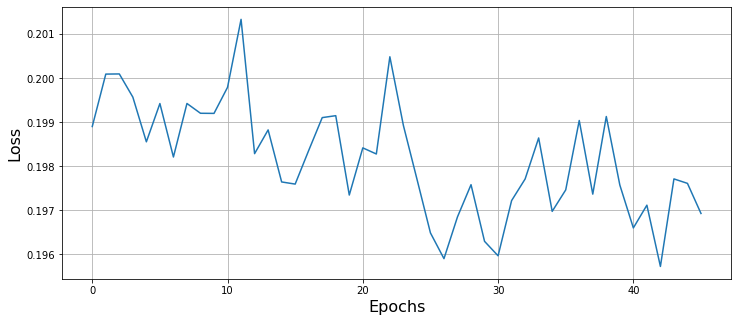

  9%|▉         | 46/500 [1:19:19<14:20:44, 113.75s/it]

Epoch 46... Loss: 0.196


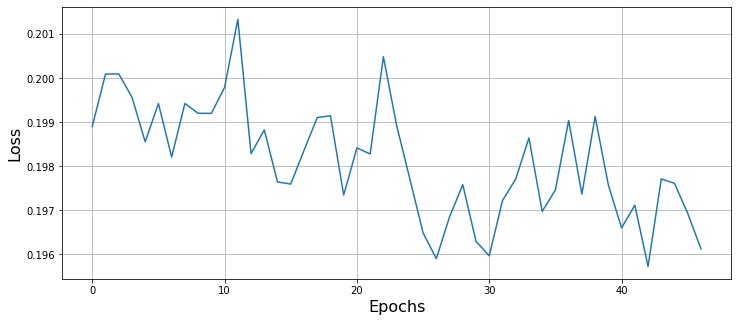

  9%|▉         | 47/500 [1:20:55<13:38:10, 108.37s/it]

Epoch 47... Loss: 0.196


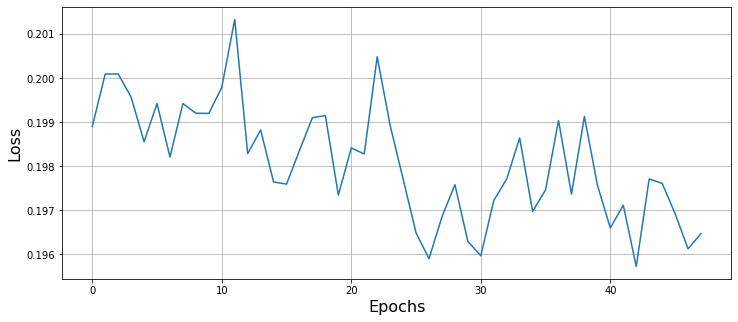

 10%|▉         | 48/500 [1:22:17<12:38:21, 100.67s/it]

Epoch 48... Loss: 0.197


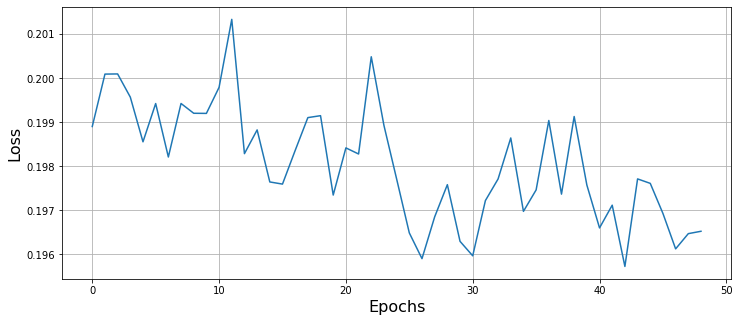

 10%|▉         | 49/500 [1:23:39<11:53:12, 94.88s/it] 

Epoch 49... Loss: 0.196


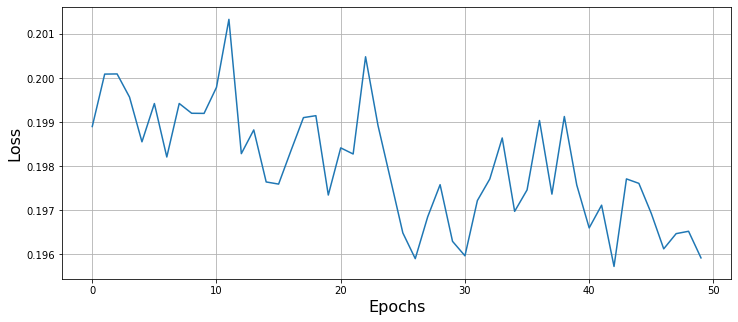

 10%|█         | 50/500 [1:24:57<11:13:04, 89.74s/it]

Epoch 50... Loss: 0.198


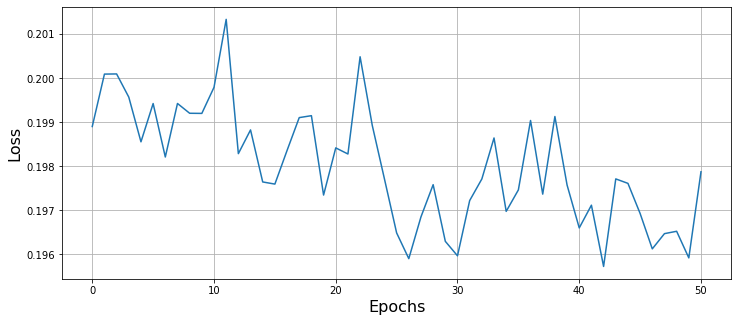

 10%|█         | 51/500 [1:26:16<10:47:24, 86.51s/it]

Epoch 51... Loss: 0.197


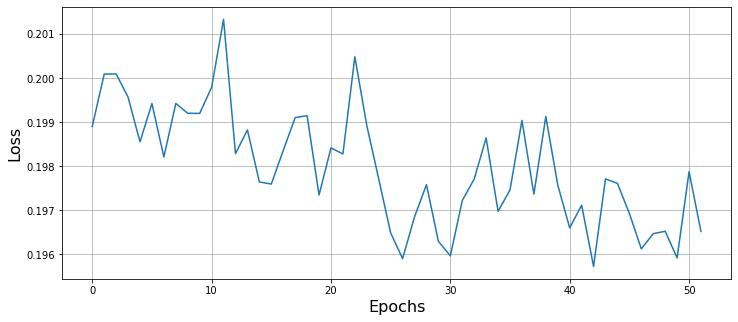

 10%|█         | 52/500 [1:27:37<10:33:43, 84.87s/it]

Epoch 52... Loss: 0.197


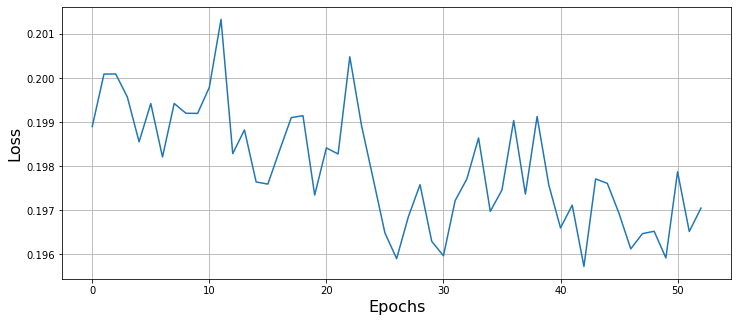

 11%|█         | 53/500 [1:28:57<10:23:17, 83.66s/it]

NameError: name 'tolerate_keyboard_interrupt' is not defined

In [13]:
train(train_loader, 500,model, 0.001)

In [14]:
import pickle
with open('modelnew.piclke', 'wb+') as f:
    pickle.dump(model, f)

In [15]:
class TestDataset():
    def __init__(self,path,source_transform):
        self.datas = t.load(path)
        self.s_transform = source_transform
    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        img = self.s_transform(img)
        return img
    def __len__(self):
        return len(self.datas)

testset = TestDataset(TEST_PATH, s_trans)
testdataloader = t.utils.data.DataLoader(testset,batch_size=1)

In [16]:
s_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize((400, 400)),
    tsf.ToTensor(),
    tsf.Normalize(mean = [0.5, 0.5, 0.5],std = [0.5, 0.5, 0.5])
])
class TestDataset():
    def __init__(self,path,source_transform):
        self.datas = t.load(path)
        self.s_transform = source_transform
    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        img = self.s_transform(img)
        return img
    def __len__(self):
        return len(self.datas)

testset = TestDataset(TEST_PATH, s_trans)
testdataloader = t.utils.data.DataLoader(testset,batch_size=1)

In [17]:
import skimage.transform

In [18]:
import scipy.misc

In [19]:
import imageio

In [20]:
model = model.eval()
for ex_id, data in enumerate(testdataloader):
    data = t.autograd.Variable(data, volatile=True)
    o = model(data)
    
    source_image = io.imread("test/images/%s_test.tif" % str(ex_id + 1).zfill(2))
    tm = o[0][0].data.cpu().numpy()
    tm = skimage.transform.resize(tm, source_image.shape[:-1])
    tm = (tm > 0.5).astype(int)
    
    imageio.imwrite("result/%s.png" % (ex_id + 1), tm)

/home/sargeras/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/sargeras/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/sargeras/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/skimage/external/tifffile/tifffile.py:2618: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int

# Вывод

В данном соревновании сначала я решил попробовать предложенную архитектуру UNET без каких-либо аугментаций. Обучал батчами размера 8. Результат был не слишком впечатляющим:скор около 0.6, далее сеть не хотела обучаться. Тогда я решил добавить аугментации в виде аффинных преобразований. Результат улучшился до 0.67. Тогда я попробовал использовать вместо UNet ResNet(0.64) и VGG16(0.66). После этого я решил увеличить разрешение картинки, но размер батча пришлось уменьшить до 3, так как не хватало оперативной памяти. Результат поднялся до 0.76. Тогда я поставил большее число эпох и в конце концов таким образом удалось побить бейзлайн. Из лосса пробовал mse еще и mae, но с ними результат оказался сильно хуже. Я думаю, что UNET показывает себя лучше всего, так как она была создана как раз для сегментации медицинских изображений и настроена на то, чтобы делать на небольшом датасете более точную сегментацию.